## Assignment 2 - Convolutional Neural Networks

In this assignment, you will learn how to implement CNN which you've learnt in the module 2. As a part of this assignment, you will perform image classification using CNNs in PyTorch. The dataset which you'll be using in this assignment will be the standard CIFAR-10 dataset. One important thing you need to know about CIFAR-10 dataset is that the image dimensions in this dataset is 32 $\times$ 32, which is not as same as the MNIST dataset dimension which you might've used while learning FNNs. This notebook contains some pre-written code blocks and some empty cells which you need to fill to build a CNN and perform Image Classification. <br>

### Importing Libraries

In [1]:
# PyTorch Library
import torch
# PyTorch Neural Network
import torch.nn as nn
import torch.nn.functional as F
# Allows us to transform data
import torchvision.transforms as transforms
# Allows us to download the dataset
import torchvision.datasets as dsets
# Used to graph data and loss curves
import matplotlib.pyplot as plt
# Allows us to use arrays to manipulate and store data
import numpy as np
import random
import seaborn

In [2]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(42)

### Load Dataset


In [3]:
### DO NOT CHANGE THIS CODE

composed = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train = dsets.CIFAR10(root='./data', train=True, download=True, transform=composed)
test = dsets.CIFAR10(root='./data', train=False, download=True, transform=composed)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
from torch.utils.data import random_split, DataLoader

train_ds, val_ds = random_split(train, [45000,5000])
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

### Training/Testing Split

Load Dataset<br>
Split the dataset into x_train, y_train, x_test, y_test

In [5]:
#training
x_trainnp= train.data[train_ds.indices]
x_train = torch.from_numpy(x_trainnp)
y_train = []
for index in train_ds.indices:
    y_train.append(train.targets[index])
#validation
x_valnp = train.data[val_ds.indices]
x_val = torch.from_numpy(x_valnp)
y_val = []
for index in val_ds.indices:
    y_val.append(train.targets[index])
#testing
x_testnp = test.data
x_test = torch.from_numpy(x_testnp)
y_test = test.targets
#classes
classes = train.classes

### Display Images and Label

Choose 16 images randomly and display them aling with their labels in a 4x4 grid



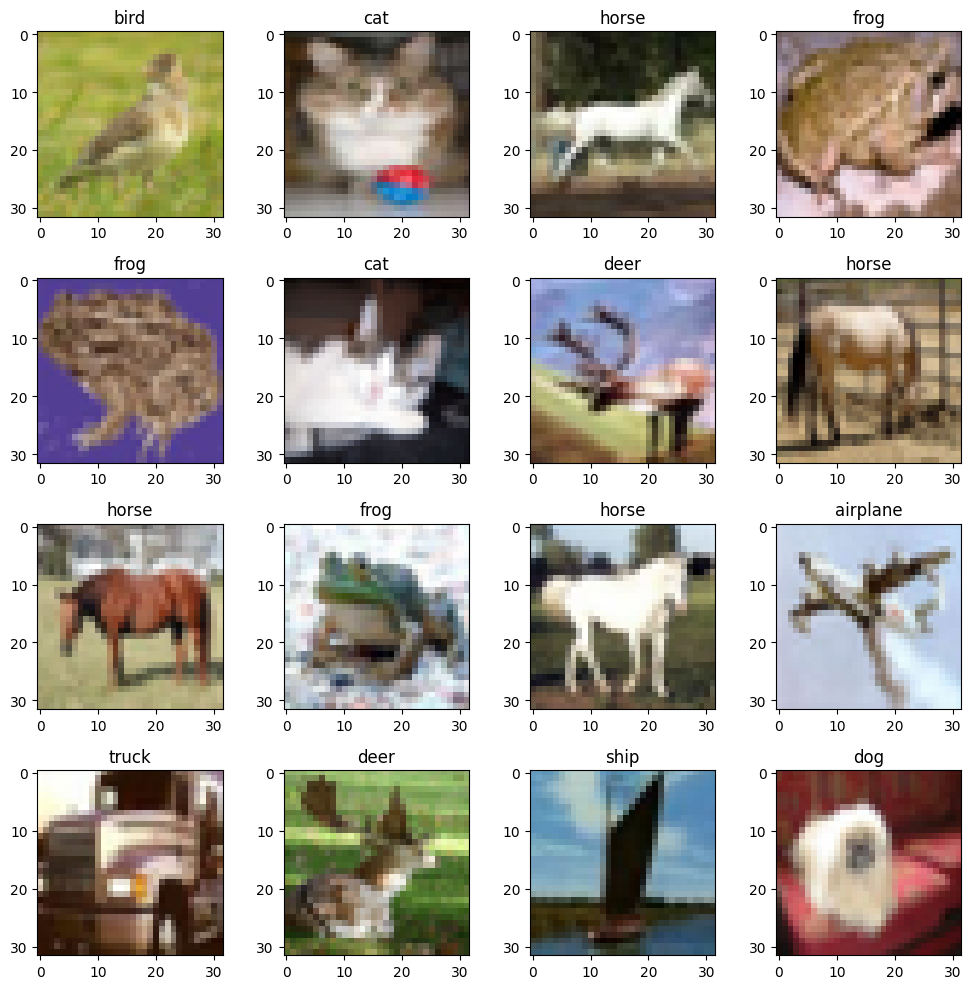

In [6]:
#A function to show an image given its normalized image vector, and label\n"
def show_image(image,label):
    plt.imshow(image)
    plt.title(classes[label])

#A function to show image in 4x4 grid, given a position\n",
def show_16image(image,label,ax):
    ax.imshow(image)
    ax.set_title(classes[label])
    
#Random 16 images shown from the training dataset\n",
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
random_images = np.random.choice(len(x_train),size=16,replace=False)
n=0
#iterating over the grid, to show images at each subplot\n",
for i in range(0,4):
    for j in range (0,4):
        ax=axs[i,j]
        show_16image(x_train[random_images[n]],y_train[random_images[n]],ax)
        n+=1
plt.tight_layout()
plt.show()

### Modelling

Define a class which will form the architecture of your CNN model


In [7]:
#So we would go with 4 Convolution layers, with their respective relu and max pooling layers. The first one would have 32 kernels,\n",
#the kernels keep on increasing as we move ahead to the layers, because more features are needed to be extracted ahead, finally \n",
#we have our 256*2*2 feature map, which is than flattened so as to work as an input for the FC layers, we have 3 FC layers, amongst which\n",
#one is the final output layer, which gives the probabilities of the 10 classes.

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding = 1)
        self.conv2 = nn.Conv2d(32,64,3, padding=1)
        self.conv3 = nn.Conv2d(64,128,3,padding =1)
        self.conv4 = nn.Conv2d(128,256,3,padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2) #halves the frame
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,64)
        self.fc3 = nn.Linear(64,10)

    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x))) # outputs 32*16*16
        x=self.pool(F.relu(self.conv2(x))) # outputs 64*8*8
        x=self.pool(F.relu(self.conv3(x))) # outputs 128*4*4
        x=self.pool(F.relu(self.conv4(x))) #outputs 256*2*2
        x=x.view(-1,1024)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x #outputs 10

### Training


Define the Convolutional Neural Network Classifier, Criterion function, Optimizer, and Train the Model

In [8]:
# define criterion function, optimizer, learning rate, number of epochs
# define 2 lists where you will store the cost and accuracy for each epoch

import torch.optim as optim
    
CNNmodel=CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNNmodel.parameters(), lr=0.001, momentum=0.9)

def train_model(num_epochs):
    loss_history={'train':[],'val':[]}
    acc_history={'train':[],'val':[]}
    
    for epochs in range(num_epochs):
        train_loss=0
        val_loss=0
        train_correct=0
        val_correct=0
        total_trained=0
        total_val=0
        
        #Training
        CNNmodel.train()
        for images,labels in train_loader:
            optimizer.zero_grad()
            output=CNNmodel(images)
            loss=criterion(output,labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()
            max_prob,pred = torch.max(output,1)
            i=0
            #for accuracy
            for i in range(len(labels)):
                total_trained+=1
                if (labels[i]==pred[i]):
                    train_correct+=1
                    
        #Validation
        CNNmodel.eval()
        for images,labels in val_loader:
            output=CNNmodel(images)
            loss=criterion(output,labels)
            val_loss += loss.item()
            max_prob,pred = torch.max(output,1) #gives us two outputs, one being the list of probabilities, and the other being index of the final output
            i=0
            #for accuracy
            for i in range(len(labels)):
                total_val+=1
                if (labels[i]==pred[i]):
                    val_correct+=1
        
        loss_history['train'].append(train_loss/(len(train_loader)))
        loss_history['val'].append(val_loss/(len(val_loader)))
        
        train_acc= 100*(train_correct/total_trained)
        val_acc = 100*(val_correct/total_val)
        acc_history['train'].append(train_acc)
        acc_history['val'].append(val_acc)
        
        print(f"Epoch: {epochs + 1}")
        print(f"Training:: Loss : {loss_history['train'][epochs]} Accuracy: {train_acc}")
        print(f"Validation:: Loss : {loss_history['val'][epochs]} Accuracy: {val_acc}")
              
              
    print(f"Final Training Accuracy: {train_acc} %")
    print(f"Final Validation Accuracy: {val_acc} %")
   
    return (loss_history,acc_history)


## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [9]:
#Let us train the model
#We use the SGD with momentum optimizer

CNNmodel=CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNNmodel.parameters(), lr=0.001, momentum=0.9)
batch_size=64
loss_history,acc_history = train_model(35)

Epoch: 1
Training:: Loss : 2.303256646137346 Accuracy: 10.064444444444444
Validation:: Loss : 2.302925043468234 Accuracy: 9.42
Epoch: 2
Training:: Loss : 2.3013875877315346 Accuracy: 12.353333333333333
Validation:: Loss : 2.301020884815651 Accuracy: 12.94
Epoch: 3
Training:: Loss : 2.2990883626043797 Accuracy: 13.655555555555557
Validation:: Loss : 2.2974278323258024 Accuracy: 13.98
Epoch: 4
Training:: Loss : 2.2886672737923535 Accuracy: 14.777777777777779
Validation:: Loss : 2.271782078320467 Accuracy: 13.94
Epoch: 5
Training:: Loss : 2.1719028172506527 Accuracy: 20.262222222222224
Validation:: Loss : 2.0537760589696186 Accuracy: 24.46
Epoch: 6
Training:: Loss : 1.965193985030055 Accuracy: 27.453333333333337
Validation:: Loss : 1.8951443629928781 Accuracy: 30.04
Epoch: 7
Training:: Loss : 1.7833217274058948 Accuracy: 33.666666666666664
Validation:: Loss : 1.7695702661441852 Accuracy: 34.14
Epoch: 8
Training:: Loss : 1.6446838041936809 Accuracy: 38.355555555555554
Validation:: Loss : 1

### Analyze Results

Plot the Loss and Accuracy vs Epoch graph

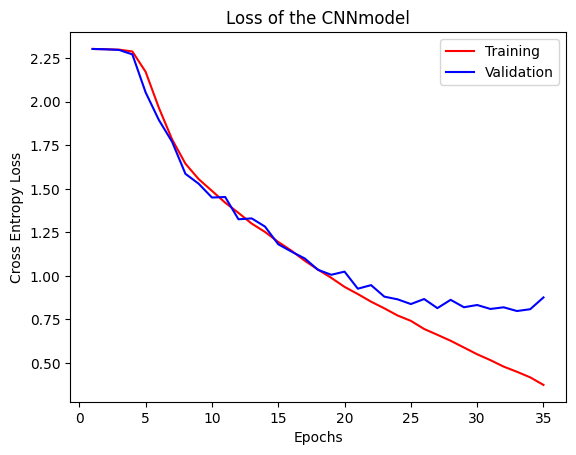

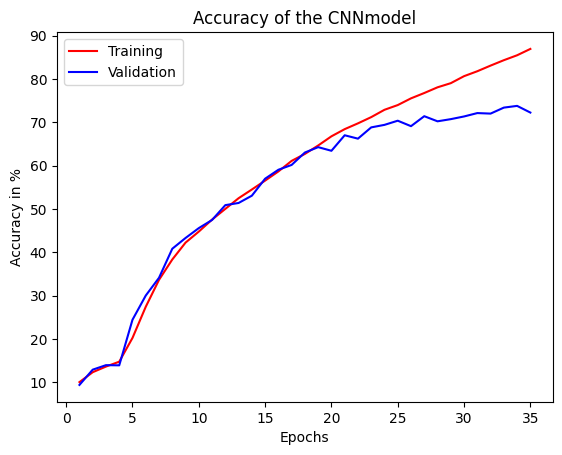

In [12]:
#Plotting the loss and Accuracy vs Epoch graph for both training and validation sets
epochs_list=np.arange(1,36,1)
plt.plot(epochs_list,loss_history['train'], color='red',label="Training")
plt.plot(epochs_list,loss_history['val'], color='blue',label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.title("Loss of the CNNmodel")
plt.legend()
plt.show()
plt.plot(epochs_list,acc_history['train'], color='red',label="Training")
plt.plot(epochs_list,acc_history['val'], color='blue',label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy in %")
plt.title("Accuracy of the CNNmodel")
plt.legend()
plt.show()

In [13]:
#TESTING PHASE
test_loader = DataLoader(test, batch_size=64, shuffle=True)
def test(model):
    test_loss=0
    total_tested=0
    test_correct=0
    for images,labels in test_loader:
        output=CNNmodel(images)
        loss=criterion(output,labels)
        test_loss+=loss.item()
        max_prob,pred = torch.max(output,1)
        i=0
        for i in range(len(labels)):
            total_tested+=1
            if (labels[i]==pred[i]):
                test_correct+=1
    
    test_acc= 100*(test_correct/total_tested)
    test_loss = test_loss/len(test_loader)

    
    print(f"Overall Testing Accuracy: {test_acc} %")
    print(f"Testing Loss: {test_loss}")
    
    return (test_acc,test_loss)

In [14]:
test_acc,test_loss = test(CNNmodel)

Overall Testing Accuracy: 73.1 %
Testing Loss: 0.9079595346739338


### Submission

Create another folder named **Week 2** in your Github Repo.<br>
Save the trained model in a file named ```final_model.pt```. When you are done with the assignment, commit the updated notebook, and the ```final_model.pt``` model-weights file to Github Repo.

In [15]:
torch.save(CNNmodel.state_dict(), "final_model.pt")

### Load the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

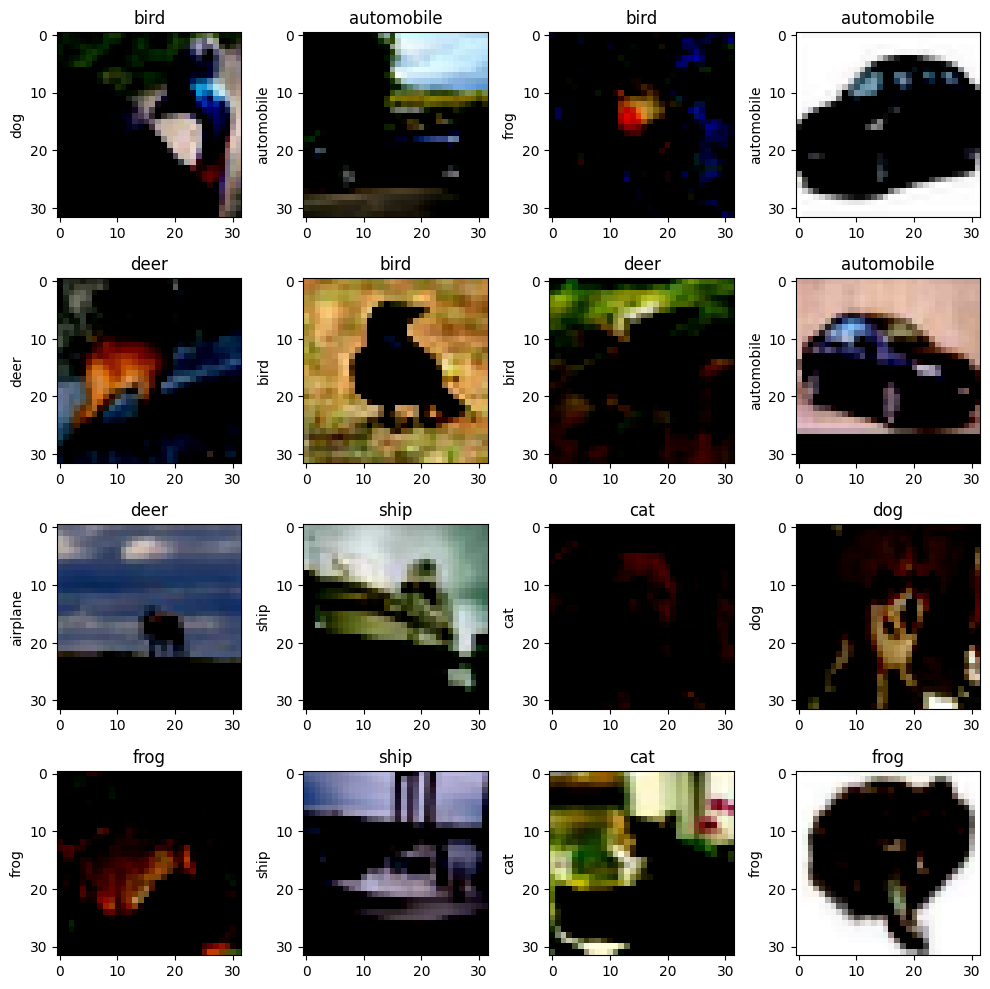

In [17]:
# Load the saved model and Make prediction on few images and display them the same way as before
CNNmodel1=CNN()
CNNmodel1.load_state_dict(torch.load("final_model.pt"))
    
#Random 16 images shown from the testing dataset
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
n=0
#iterating over the grid, to show images at each subplot
for images, labels in test_loader:
    for i in range(0,4):
        for j in range (0,4):
            ax=axs[i,j]
            max_prob, pred=torch.max(CNNmodel1(images[n]),1)
            show_16image(images[n].permute(1,2,0),labels[n],ax)
            ax.set_ylabel(classes[pred])
            n+=1
    break
plt.tight_layout()
plt.show()